Saved 3000 car images to ./cifar100_cars
Saved 3000 non-car images to ./cifar100_non_cars



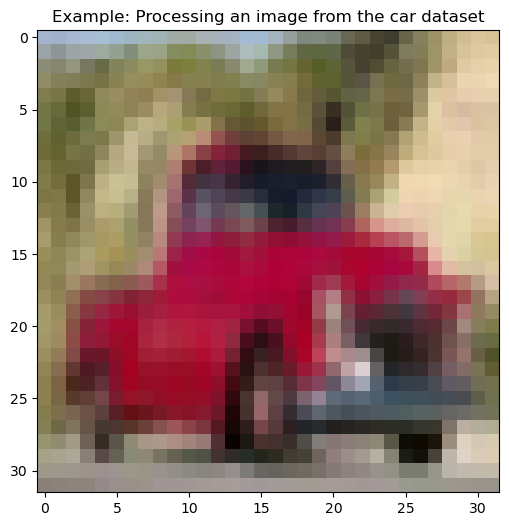

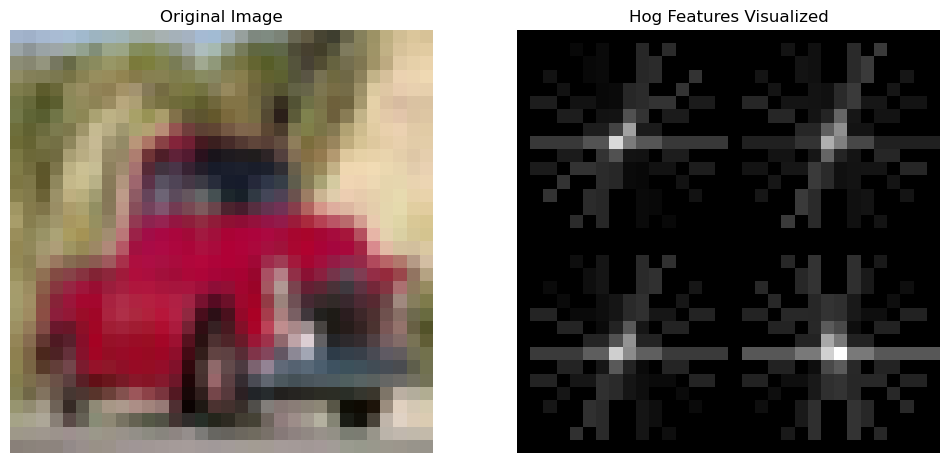


Begin extracting HOG features for positive and negative images (This will take a while)
Reading images and extracting features has taken 57.83 seconds
Shape of image set (6000, 540)
Shape of labels (6000,)

Split data into training and test sets
x_train: (4800, 540)
x_test: (1200, 540)
y_train: (4800,)
y_test: (1200,)

Creating an SVC object (This will take even longer)
[LibSVM]Accuracy score of model is  85.17


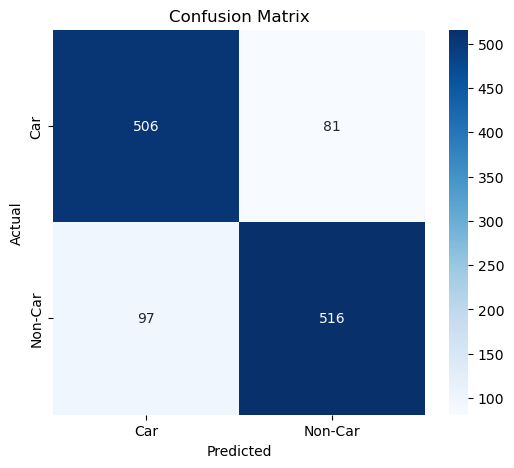


Test multiple images
True label:  Not car
Prediction: Not car


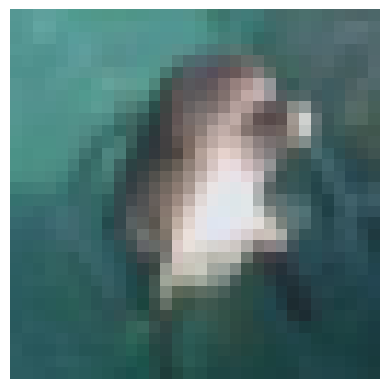

True label:  Car
Prediction: Car


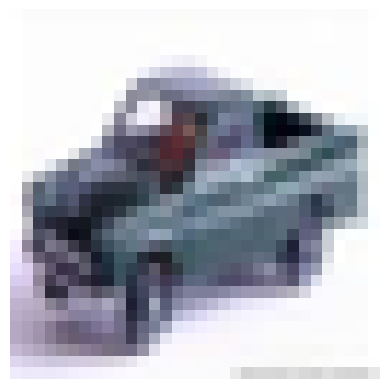

True label:  Car
Prediction: Car


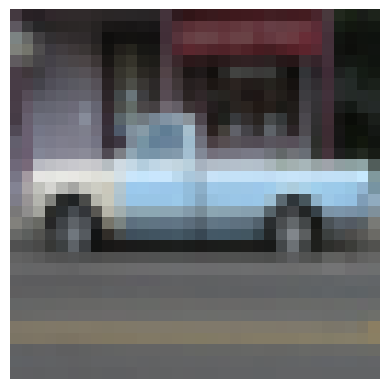

True label:  Not car
Prediction: Not car


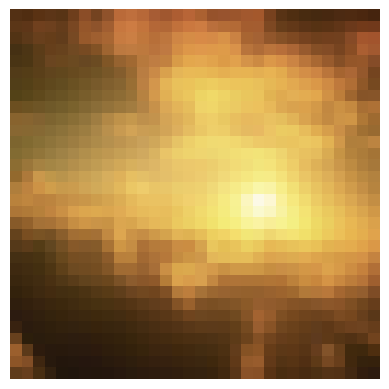


Test different Regularization Values (This will take the longest)
Accuracy score of svc model is  85.17
Accuracy score of svc1 model with c=0.01 is  69.58
Accuracy score of svc2 model with c=100 is  84.42

Test SVC (c=100)
True label:  Not car
Prediction: Car


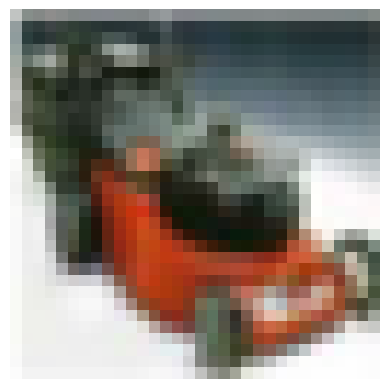

True label:  Not car
Prediction: Not car


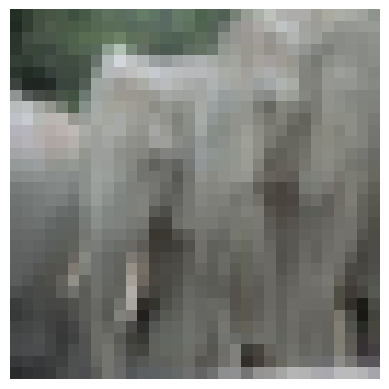


Checking for overfitting
Accuracy for svc with c=1.0: 0.8108 (+/- 0.0360)
Accuracy for svc with c=0.01: 0.5108 (+/- 0.0041)
Accuracy for svc with c=100: 0.8050 (+/- 0.0133)


In [13]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import PIL
import cv2
import pickle

from PIL import Image
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm

from IPython.display import display

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

"""
Pre-processing
"""

# Load CIFAR-100
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

# Identify car-related class names
car_class_names = ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'streetcar', 'tractor']
car_indices = [cifar100.class_to_idx[name] for name in car_class_names]

# Output directory for car images
output_car_dir = './cifar100_cars'
os.makedirs(output_car_dir, exist_ok=True)

# Save only car images to directory
count = 0
for i in range(len(cifar100)):
    img, label = cifar100[i]
    if label in car_indices:
        img.save(os.path.join(output_car_dir, f"car_{count}.png"))
        count += 1

# Identify non-car class names
non_car_class_names = [class_name for class_name in cifar100.classes if class_name not in car_class_names]
non_car_indices = [cifar100.class_to_idx[name] for name in non_car_class_names]

# Output directory for non-car images
output_non_car_dir = './cifar100_non_cars'
os.makedirs(output_non_car_dir, exist_ok=True)

# Save 3000 random non-car images to directory
num_images = 3000
count_non_car = 0
sampled_images = []
non_car_indices_list = [i for i in range(len(cifar100)) if cifar100.targets[i] in non_car_indices]
random_indices = random.sample(non_car_indices_list, num_images)
for idx in random_indices:
    img, label = cifar100[idx]
    img.save(os.path.join(output_non_car_dir, f"non_car{count_non_car}.png"))
    count_non_car += 1

print(f"Saved {count} car images to {output_car_dir}")
print(f"Saved {count_non_car} non-car images to {output_non_car_dir}\n")

# Get file paths of saved car and non-car images
car_paths = glob(output_car_dir + "/*.png")
non_car_paths = glob(output_non_car_dir + "/*.png")

example_image = np.asarray(PIL.Image.open(car_paths[894]))
fig = plt.figure(figsize=(12, 6))
plt.title("Example: Processing an image from the car dataset")
plt.imshow(example_image)
example_image.shape

# Use HOG to focus on the shape of an image
hog_features, visualized = hog(image=example_image,
                               orientations=9,
                               pixels_per_cell=(16, 16),
                               cells_per_block=(2, 2),
                               visualize=True,
                               channel_axis=-1)

# Plot the original image
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(example_image)
plt.title("Original Image")
plt.axis("off")

# Plot the HOG visualized image
fig.add_subplot(1, 2, 2)
plt.imshow(visualized, cmap="gray")
plt.title("Hog Features Visualized")
plt.axis("off")

plt.show()

# hog_features is a vector
hog_features.shape

pos_images = []
neg_images = []

# Labels: 1 for car, 0 for non-car
pos_labels = np.ones(len(car_paths))
neg_labels = np.zeros(len(non_car_paths))

# Start timer to measure processing time
start = time.time()
print("\nBegin extracting HOG features for positive and negative images (This will take a while)")

# Extract HOG features for positive images (cars)
for car_path in car_paths:
    img = np.asarray(PIL.Image.open(car_path))
    # We don't need RGB channels
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    pos_images.append(img)
    
# Extract HOG features for negative images (non-cars)
for non_car_path in non_car_paths:
    img = np.asarray(PIL.Image.open(non_car_path))
    img = cv2.cvtColor(cv2.resize(img, (96,64)), cv2.COLOR_RGB2GRAY)
    img = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
    neg_images.append(img)

# Stack positive and negative images
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

processTime = round(time.time()-start, 2)
print(f"Reading images and extracting features has taken {processTime} seconds")

print("Shape of image set", x.shape)
print("Shape of labels", y.shape)

"""
Split data into train and test
"""

print("\nSplit data into training and test sets")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Creating a SVC object
print("\nCreating an SVC object (This will take even longer)")
svc = SVC(kernel = 'rbf', verbose=True, random_state=SEED)

# Fit the training dataset
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Car", "Non-Car"], yticklabels=["Car", "Non-Car"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Test a model's prediction on a single image
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img, (96, 64)), cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray, orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)

    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])

    print("True label: ", true_label)
    
    if pred[0] == 0.0:
        print("Prediction: Not car")
        
    elif pred[0] == 1.0:
        print("Prediction: Car")
        
    plt.imshow(img)
    plt.axis("off")
    plt.show()

print("\nTest multiple images")
test_prediction(non_car_paths[479], "Not car", svc)
test_prediction(car_paths[1300], "Car", svc)
test_prediction(car_paths[10], "Car", svc)
test_prediction(non_car_paths[-78], "Not car", svc)

"""
Testing for different values of Regularization
"""

# Creating a SVC object
print("\nTest different Regularization Values (This will take the longest)")
svc = SVC()
svc1 = SVC(C=0.01)
svc2 = SVC(C=100)

# Fitting the parameters
svc.fit(x_train,y_train)
svc1.fit(x_train,y_train)
svc2.fit(x_train,y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of svc model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc1.predict(x_test)
print("Accuracy score of svc1 model with c=0.01 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

y_pred = svc2.predict(x_test)
print("Accuracy score of svc2 model with c=100 is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100,2))

print("\nTest SVC (c=100)")
test_prediction(non_car_paths[90], "Not car", svc2)
test_prediction(non_car_paths[2000], "Not car", svc2)

"""
Checking for overfitting
"""
print("\nChecking for overfitting")
scores = cross_val_score(svc, x_test, y_test, cv=5)
scores1 = cross_val_score(svc1, x_test, y_test, cv=5)
scores2 = cross_val_score(svc2, x_test, y_test, cv=5)
print("Accuracy for svc with c=1.0: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
print("Accuracy for svc with c=0.01: %0.4f (+/- %0.4f)" % (scores1.mean(), scores1.std() * 2))
print("Accuracy for svc with c=100: %0.4f (+/- %0.4f)" % (scores2.mean(), scores2.std() * 2))